In [4]:
import subprocess
import sys


# 需要的库
libraries = [
    "pandas", "numpy", "matplotlib", "torch", "scipy", "sklearn", "PIL",
    "scikit-image","ta"
]

# 自动安装缺失的库
def install_if_missing(lib_name):
    try:
        __import__(lib_name)
    except ImportError:
        print(f"Installing {lib_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", lib_name])

# 遍历所有库，逐个检查并安装
for lib in libraries:
    install_if_missing(lib)

# 现在可以正常导入所有库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.signal import argrelmax
import os
import random
from PIL import Image
from skimage.io import imread
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import color

print("All libraries are installed and imported successfully!")


Installing scikit-image...
Installing ta...
All libraries are installed and imported successfully!


In [5]:
import pandas as pd
import ta

# 加载数据
data = pd.read_csv('./data.csv')
data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d')

# 移除无效行
rows = [x for x in data.index if data.loc[x]['Open'] == 0]
data = data.drop(rows, axis=0)

# =======================
# 增加特征
# =======================

# 1. 技术指标
data['MA20'] = data['Close'].rolling(window=20).mean()  # 20日移动均线
data['EMA10'] = ta.trend.ema_indicator(data['Close'], window=10)  # 10日指数移动均线
data['RSI'] = ta.momentum.rsi(data['Close'], window=14)  # RSI
data['MACD'] = ta.trend.macd(data['Close'])  # MACD指标
data['Bollinger_High'] = ta.volatility.bollinger_hband(data['Close'])
data['Bollinger_Low'] = ta.volatility.bollinger_lband(data['Close'])

# 2. 统计特征
data['Close_Mean_10'] = data['Close'].rolling(window=10).mean()  # 10日均值
data['Close_Std_10'] = data['Close'].rolling(window=10).std()    # 10日标准差
data['Daily_Return'] = data['Close'].pct_change()                # 日收益率

# 3. 时间特征
data['day_of_week'] = data['Date'].dt.dayofweek  # 周几 (0=Monday, 6=Sunday)
data['month'] = data['Date'].dt.month            # 月份
data['quarter'] = data['Date'].dt.quarter        # 季度
data['is_month_end'] = data['Date'].dt.is_month_end.astype(int)  # 是否月末

# 4. 相关性特征 (28天滚动相关系数)
data['PE_Close_Corr'] = data['Close'].rolling(window=28).corr(data['PE'])

# 移除空值行
data = data.dropna().reset_index(drop=True)

# 查看前几行，确认特征生成成功
print(data.head())

# 保存处理后的数据
data.to_csv('./processed_data.csv', index=False)


        Date      Close       Open       High        Low     PE    MA20  \
0 1960-02-10  55.490002  55.490002  55.490002  55.490002  17.55  56.685   
1 1960-02-11  55.180000  55.180000  55.180000  55.180000  17.55  56.524   
2 1960-02-12  55.459999  55.459999  55.459999  55.459999  17.55  56.378   
3 1960-02-15  55.169998  55.169998  55.169998  55.169998  17.55  56.242   
4 1960-02-16  54.730000  54.730000  54.730000  54.730000  17.55  56.115   

       EMA10        RSI      MACD  Bollinger_High  Bollinger_Low  \
0  56.063258  31.956907 -0.859835       58.438369      54.931632   
1  55.902666  29.887143 -0.877028       58.207857      54.840143   
2  55.822181  34.042397 -0.858168       57.890476      54.865524   
3  55.703602  31.931592 -0.856746       57.673162      54.810838   
4  55.526584  28.994119 -0.880967       57.608178      54.621822   

   Close_Mean_10  Close_Std_10  Daily_Return  day_of_week  month  quarter  \
0         55.974      0.442221     -0.006268            2      

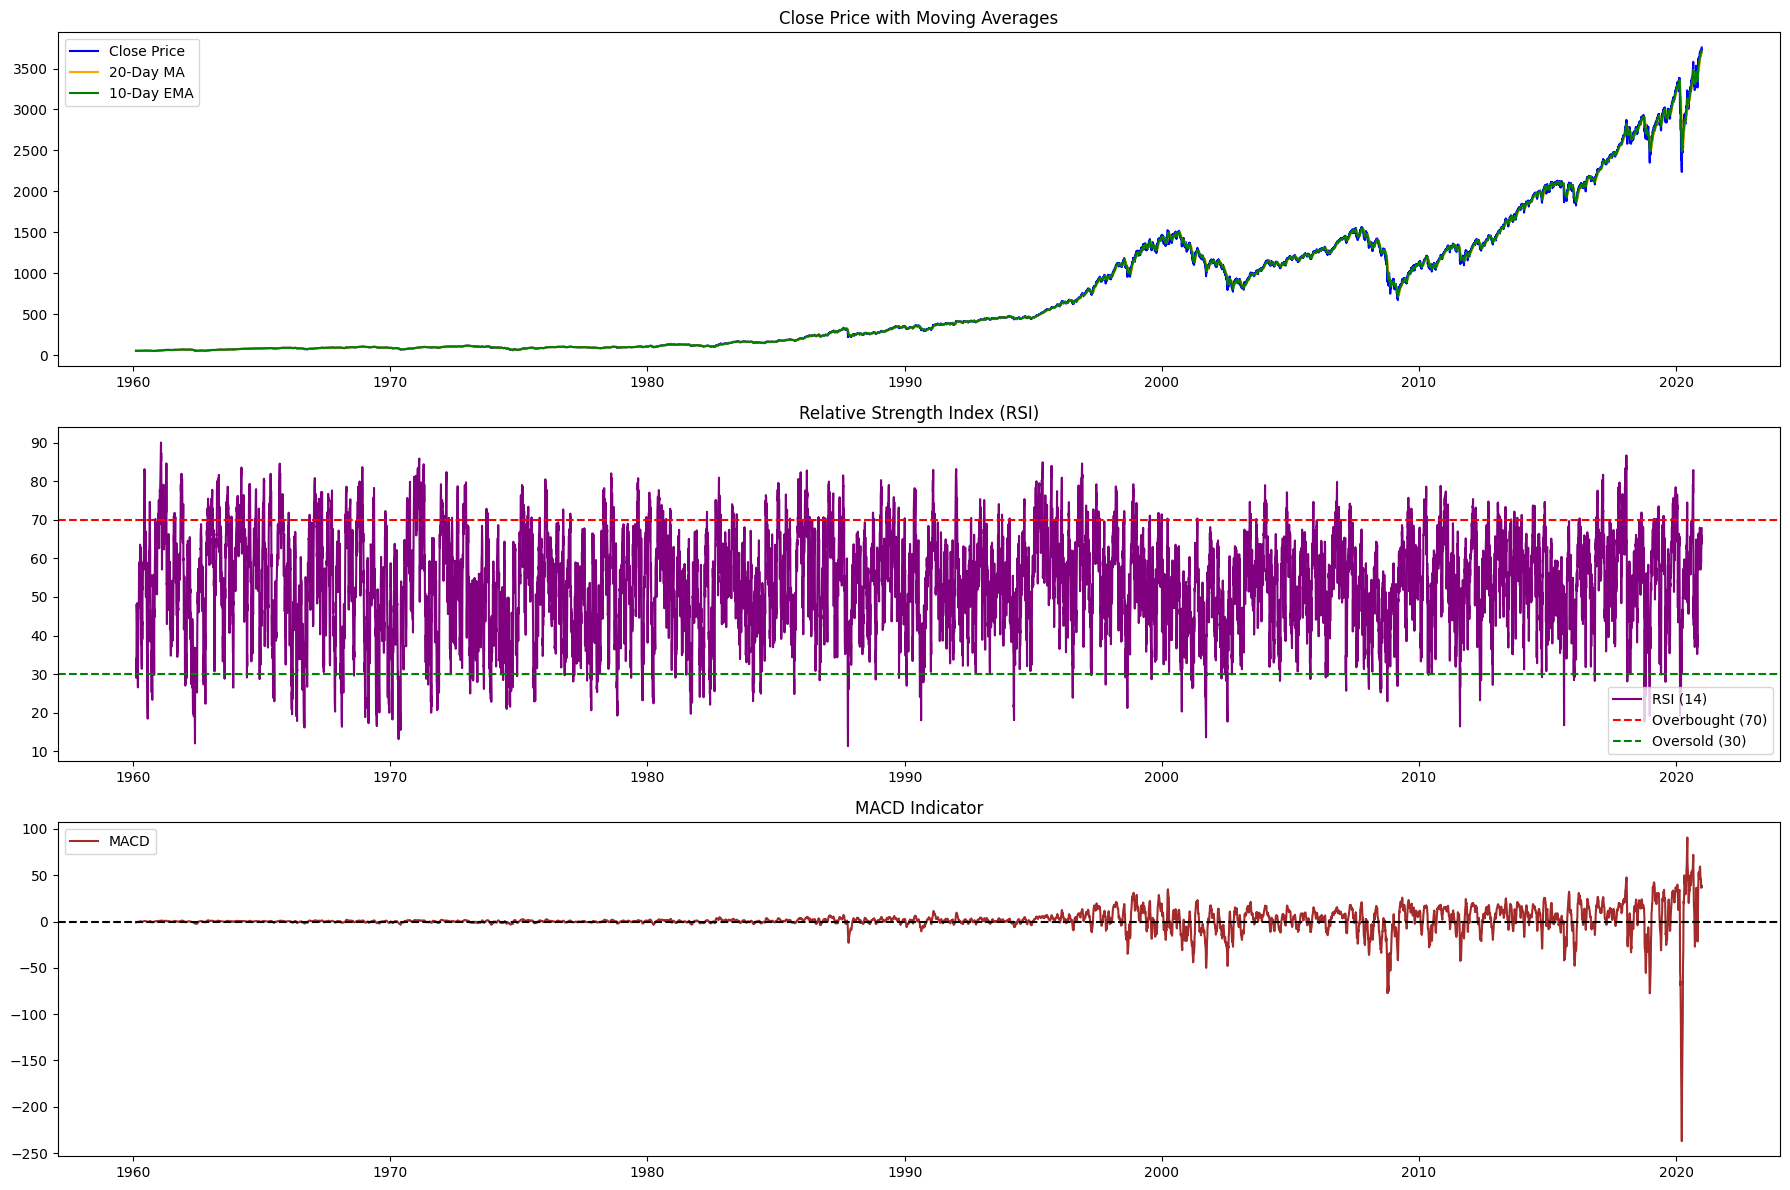

In [7]:
# 4. 绘制图表

plt.figure(figsize=(18, 12))

# (1) 收盘价 + 移动平均线
plt.subplot(3, 1, 1)
plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
plt.plot(data['Date'], data['MA20'], label='20-Day MA', color='orange')
plt.plot(data['Date'], data['EMA10'], label='10-Day EMA', color='green')
plt.title('Close Price with Moving Averages')
plt.legend()

# (2) RSI
plt.subplot(3, 1, 2)
plt.plot(data['Date'], data['RSI'], label='RSI (14)', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('Relative Strength Index (RSI)')
plt.legend()

# (3) MACD
plt.subplot(3, 1, 3)
plt.plot(data['Date'], data['MACD'], label='MACD', color='brown')
plt.axhline(0, color='black', linestyle='--')
plt.title('MACD Indicator')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
import pandas as pd

# 1. 读取处理后的数据
data = pd.read_csv('./processed_data.csv')
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# 2. 划分训练集和测试集
train_data = data[(data['Date'] >= '1980-01-01') & (data['Date'] <= '2019-12-31')]
test_data = data[data['Date'] >= '2020-01-01']

# 3. 保存训练集和测试集
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

# 4. 打印划分结果
print(f"训练集大小：{len(train_data)} 行")
print(f"测试集大小：{len(test_data)} 行")


训练集大小：10069 行
测试集大小：253 行


In [11]:
# 3. 生成 Sell 信号
curr_money = 1
money_arr = []
sell_date_arr = []

# 记录上一次卖出日
sell_day = 0  

# 循环生成卖出信号
for i in range(window_size - 1, len(data)):
    curr_price = data['Close'][(i - window_size + 1):(i + 1)].values
    rsi = data.loc[i, 'RSI']
    upper_band = data.loc[i, 'Bollinger_High']
    ema10 = data.loc[i, 'EMA10']
    ma20 = data.loc[i, 'MA20']

    #新的卖出条件
    if (rsi > 70 or curr_price[-1] >= upper_band or ema10 < ma20) and (i - sell_day > window_size):
        # 卖出价格
        sell_price = curr_price[-1]
        # 买入价格（假设买在28天窗口的最低价）
        buy_price = min(curr_price)
        # 计算收益
        curr_money = curr_money / buy_price * sell_price
        sell_day = i  # 记录卖出日期
        money_arr.append(curr_money)
        sell_date_arr.append(data.loc[i, 'Date'])

# 4. 生成二元标签 (1 = Sell, 0 = Hold)
data['label'] = 0  # 默认持有
data.loc[data['Date'].isin(sell_date_arr), 'label'] = 1

# 5. 保存结果
data.to_csv('./labeled_data.csv', index=False)

# 6. 检查结果
print(f"生成的卖出信号数量：{len(sell_date_arr)}")
print(data['label'].value_counts())
print(f"Curr Money：{curr_money}")


生成的卖出信号数量：471
label
0    14833
1      471
Name: count, dtype: int64
Curr Money：23167666.67777661


In [ ]:
# dataset = data[['Close']].values
# scaler = MinMaxScaler(feature_range = (0, 1))
# dataset = scaler.fit_transform(dataset)
# dataset.shape

(15355, 1)

KeyboardInterrupt: 

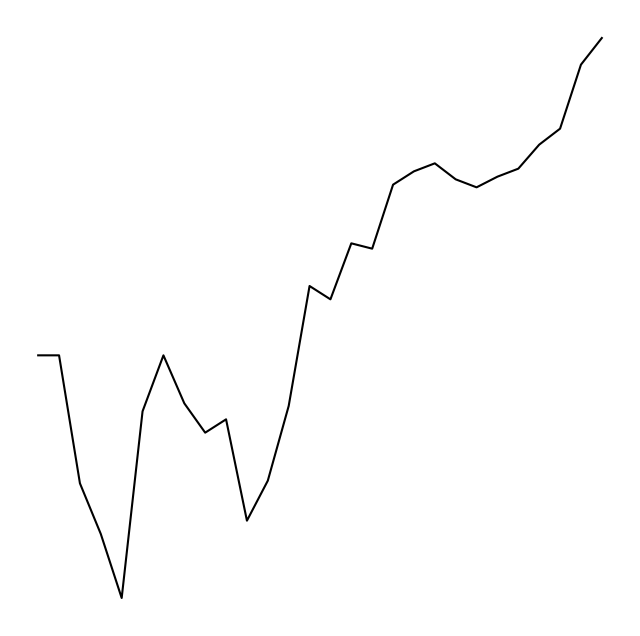

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt

# 创建文件夹，如果不存在
def create_folder(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# 🟢 生成图像的函数
def generate_image(dataset, day_num, label, window_size):
    # 1. 获取窗口内的数据
    data = []
    xaxis = np.arange(0, window_size)
    for x in reversed(range(0, window_size)):
        data.append(dataset[day_num - x][0])  # 假设第0列是Close价格

    # 2. 生成图像
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.plot(data, color="black")

    # 3. 根据标签保存到对应文件夹
    if label == 1:
        folder = './sell_images/'  # 卖出
    else:
        folder = './hold_images/'  # 持有

    # 创建对应的文件夹
    create_folder(folder)

    # 4. 保存图像
    image_name = f"{folder}day{day_num}.png"
    plt.savefig(image_name, bbox_inches='tight', pad_inches=0, dpi=100)
    plt.close()

# ========================
# 批量生成所有标签的图像
# ========================

import pandas as pd

# 1. 读取带标签的数据
data = pd.read_csv('./labeled_data.csv')

# 2. 转换为 numpy 数组
dataset = data[['Close', 'label']].values  # 只用Close和Label列

# 3. 设置窗口大小
window_size = 28  

# 4. 生成图像
for i in range(window_size - 1, len(dataset)):
    close_price = dataset[(i - window_size + 1):(i + 1), 0]  # 价格窗口
    label = dataset[i, 1]  # 卖出信号 (0=Hold, 1=Sell)
    generate_image(dataset, i, label, window_size)

print("./sell_images/ 和 ./hold_images/")


In [14]:
# import matplotlib.pyplot as plt

# def generate_image_with_markers(dataset, i, save_directory, window_size):
#     """
#     Generate an image of the price window with buy/sell markers.
#     """
#     window_data = dataset[(i - window_size + 1):(i + 1), 0]  # Extract window data
#     x_axis = range(len(window_data))  # X-axis is just index
    
#     # Find buy/sell points
#     buy_index = window_data.argmin()  # Local min (buy)
#     sell_index = window_data.argmax()  # Local max (sell)
    
#     buy_price = window_data[buy_index]
#     sell_price = window_data[sell_index]
    
#     # Plot the price curve
#     plt.figure(figsize=(5, 5))  # Adjust figure size
#     plt.plot(x_axis, window_data, color="black", linewidth=2)  # Price line
    
#     # Highlight buy point (green circle)
#     plt.scatter(buy_index, buy_price, color="green", marker='o', s=100, label="Buy Point")
    
#     # Highlight sell point (red cross)
#     plt.scatter(sell_index, sell_price, color="red", marker='x', s=100, label="Sell Point")
    
#     plt.axis('off')  # Remove axes
#     plt.legend()  # Add legend
    
#     # Save the image
#     save_path = f"{save_directory}/day{i}.png"
#     plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
#     plt.close()

# Example usage:
# generate_image_with_markers(dataset, i, "train_sell_point_image", window_size)


In [ ]:
#Create the CandaidateTrain folder manually, then run this to create all possible selling signals
# train_sell_image_directory = 'train_sell_point_image/'
# if not os.path.exists(train_sell_image_directory ):
#     os.makedirs(train_sell_image_directory )

# for i in cnn_sell_point_arr:
#     #generate_image(dataset,i,train_sell_image_directory, window_size)
#     generate_image(dataset,i,train_sell_image_directory, window_size)

<Figure size 800x800 with 0 Axes>

In [ ]:
# not sell 
# cnn_hold_point_arr = []
# prev_hold_point = 0 # 上一个hold点的下标
# for i in range(window_size-1,len(dataset)):
# #     1. corr < -0.5
# #     2. 当前hold点和前几个间隔28天
# #     3. 当前hold点的价格不能是当前window的最高点
#     if step2_data_corr[i][2] < -0.5  and i >= prev_hold_point + window_size and dataset[i][0] < max(dataset[(i-window_size+1):(i+1), 0]):
#         cnn_hold_point_arr.append(i)
#         prev_hold_point = i
# #Now, we have a candidate not selling signal list
# len(cnn_hold_point_arr)

51

In [ ]:
# train_hold_image_directory = 'train_hold_point_image/'
# if not os.path.exists(train_hold_image_directory ):
#     os.makedirs(train_hold_image_directory)

# for i in cnn_hold_point_arr:
#     #generate_image(dataset, i, train_hold_image_directory, window_size)
#     generate_image(dataset, i, train_hold_image_directory, window_size)



<Figure size 800x800 with 0 Axes>

In [17]:
import os
import numpy as np
import pandas as pd
from PIL import Image

# 文件夹路径
train_sell_image_directory = './sell_images/'  # 卖出图像路径
train_hold_image_directory = './hold_images/'  # 持有图像路径

# 🟢 1. 读取数据
data = pd.read_csv('./labeled_data.csv')

# 🟢 2. 生成卖出和持有的索引
sell_point_indices = data[data['label'] == 1].index.tolist()  # 卖出点
hold_point_indices = data[data['label'] == 0].index.tolist()  # 持有点

# ============================
# 🟡 3. 生成输入和标签
# ============================
cnn_input = []
cnn_label = []

# 🚀 处理卖出图像 (label = 1)
for img_index in sell_point_indices:
    image_path = os.path.join(train_sell_image_directory, f'day{img_index}.png')
    if os.path.exists(image_path):
        img = Image.open(image_path)
        img = img.convert("L")  # 灰度
        img_resize = img.resize((180, 180))  # 统一尺寸
        cnn_input.append(np.asarray(img_resize) / 255.0)  # 归一化
        cnn_label.append(1)  # 卖出标签

# 🚀 处理持有图像 (label = 0)
for img_index in hold_point_indices:
    image_path = os.path.join(train_hold_image_directory, f'day{img_index}.png')
    if os.path.exists(image_path):
        img = Image.open(image_path)
        img = img.convert("L")
        img_resize = img.resize((180, 180))
        cnn_input.append(np.asarray(img_resize) / 255.0)
        cnn_label.append(0)  # 持有标签

# ============================
# 🔢 4. 转换为 NumPy 数组
# ============================
cnn_input = np.array(cnn_input)
cnn_label = np.array(cnn_label)

print(f"📏 CNN 输入形状：{cnn_input.shape}")
print(f"🔖 CNN 标签形状：{cnn_label.shape}")

# ============================
# 🟡 5. 划分训练集和验证集 (80/20 Split)
# ============================
cnn_train_input = []
cnn_train_label = []
cnn_val_input = []
cnn_val_label = []

# 🚀 划分数据
for i in range(cnn_input.shape[0]):
    if i % 5 == 4:  # 20% 验证集
        cnn_val_input.append(cnn_input[i])
        cnn_val_label.append(cnn_label[i])
    else:  # 80% 训练集
        cnn_train_input.append(cnn_input[i])
        cnn_train_label.append(cnn_label[i])

# 🟢 转换为 NumPy 数组
cnn_train_input = np.array(cnn_train_input)
cnn_train_label = np.array(cnn_train_label)
cnn_val_input = np.array(cnn_val_input)
cnn_val_label = np.array(cnn_val_label)

# ============================
# ✅ 6. 验证输出
# ============================
print(f"✅ 训练集输入：{cnn_train_input.shape}, 训练集标签：{cnn_train_label.shape}")
print(f"✅ 验证集输入：{cnn_val_input.shape}, 验证集标签：{cnn_val_label.shape}")



📏 CNN 输入形状：(15277, 180, 180)
🔖 CNN 标签形状：(15277,)
✅ 训练集输入：(12222, 180, 180), 训练集标签：(12222,)
✅ 验证集输入：(3055, 180, 180), 验证集标签：(3055,)


In [18]:
import torch
import numpy as np

# ============================
# 🟢 1. 转换训练集为 Torch 格式
# ============================

# 将输入 reshaped 为 (batch_size, channels, height, width)
cnn_train_input = cnn_train_input.reshape(cnn_train_input.shape[0], 1, cnn_train_input.shape[1], cnn_train_input.shape[2])
cnn_train_input = torch.from_numpy(cnn_train_input.astype(np.float32))

# 将标签转换为整数类型的 Tensor
cnn_train_label = torch.from_numpy(cnn_train_label.astype(int))

# ============================
# 🟡 2. 转换验证集为 Torch 格式
# ============================

cnn_val_input = cnn_val_input.reshape(cnn_val_input.shape[0], 1, cnn_val_input.shape[1], cnn_val_input.shape[2])
cnn_val_input = torch.from_numpy(cnn_val_input.astype(np.float32))

cnn_val_label = torch.from_numpy(cnn_val_label.astype(int))

# ============================
# ✅ 3. 打印形状以验证
# ============================

print(f"✅ 训练集输入形状：{cnn_train_input.shape}, 训练集标签形状：{cnn_train_label.shape}")
print(f"✅ 验证集输入形状：{cnn_val_input.shape}, 验证集标签形状：{cnn_val_label.shape}")


✅ 训练集输入形状：torch.Size([12222, 1, 180, 180]), 训练集标签形状：torch.Size([12222])
✅ 验证集输入形状：torch.Size([3055, 1, 180, 180]), 验证集标签形状：torch.Size([3055])


In [22]:
import torch
import torch.nn as nn

class CNN(nn.Module):   
    def __init__(self):
        super(CNN, self).__init__()
        
        # 🟢 1. 卷积层 1
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)  # 1 输入通道 → 8 输出通道
        self.batch1 = nn.BatchNorm2d(8)
        self.activate1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=2)  # 180 → 90

        # 🟡 2. 卷积层 2
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)  # 8 → 16
        self.batch2 = nn.BatchNorm2d(16)
        self.activate2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=2)  # 90 → 45

        # 🟣 3. Flatten 层（自动计算维度）
        self.flatten = nn.Flatten()

        # 🔵 4. 全连接层
        self.linear1 = nn.Linear(45 * 45 * 16, 128)  # 自动计算的维度
        self.activate3 = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.output = nn.Linear(128, 2)  # 输出二分类（Hold vs. Sell）

    # 🟠 Forward Pass
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.activate1(x)
        x = self.max_pool1(x)

        x = self.conv2(x)
        x = self.batch2(x)
        x = self.activate2(x)
        x = self.max_pool2(x)

        x = self.flatten(x)  # 自动展开
        x = self.linear1(x)
        x = self.activate3(x)
        x = self.dropout(x)
        x = self.output(x)
        return x


In [33]:
# #set seed for reproducible results
# torch.manual_seed(1)
# np.random.seed(1)
# random.seed(1)
# defining the model
cnn_learning_rate = 0.001
cnn_training_epochs = 40
cnn_model = CNN().double()
# defining the optimizer
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=cnn_learning_rate)
# defining the loss function
# 计算类别权重：Hold = 11845，Sell = 377
class_weights = torch.tensor([1.0, 11845 / 377], dtype=torch.float32).to(cnn_train_input.device)

# 加权交叉熵
criterion = nn.CrossEntropyLoss(weight=class_weights)
# 将模型权重和偏置转换为 float32
cnn_model = CNN().to(torch.float32)
cnn_model

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activate1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activate2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32400, out_features=128, bias=True)
  (activate3): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=128, out_features=2, bias=True)
)

In [34]:
print(cnn_train_label.shape)
print(cnn_train_input.shape)

torch.Size([12222])
torch.Size([12222, 1, 180, 180])


In [35]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

# 🟢 1. 创建 DataLoader (批量训练)
batch_size = 64

train_dataset = TensorDataset(cnn_train_input, cnn_train_label)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(cnn_val_input, cnn_val_label)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 🟡 2. 训练设置
cnn_training_epochs = 50
train_loss_arr = []
val_loss_arr = []

# 🟣 3. 训练过程
for epoch in range(cnn_training_epochs):
    cnn_model.train()  # 训练模式
    train_loss = 0.0

    # 🚀 3.1 训练阶段
    for inputs, labels in train_loader:
        inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad()
        output_train = cnn_model(inputs)

        loss = criterion(output_train, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_loss_arr.append(train_loss)

    # 🟠 3.2 验证阶段 (关闭梯度计算)
    cnn_model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = Variable(val_inputs), Variable(val_labels)

            output_val = cnn_model(val_inputs)
            loss_val = criterion(output_val, val_labels)

            val_loss += loss_val.item()

    val_loss /= len(val_loader)
    val_loss_arr.append(val_loss)

    # ✅ 4. 打印结果
    if epoch % 10 == 0 or epoch == cnn_training_epochs - 1:
        print(f"[{epoch}/{cnn_training_epochs}] Training Loss: {train_loss:.4f}")
        print(f"[{epoch}/{cnn_training_epochs}] Validation Loss: {val_loss:.4f}")

print("🎉 训练完成！")

    

[0/50] Training Loss: 0.6918
[0/50] Validation Loss: 0.6196
[10/50] Training Loss: 0.6992
[10/50] Validation Loss: 0.6196
[20/50] Training Loss: 0.6956
[20/50] Validation Loss: 0.6195
[30/50] Training Loss: 0.6966
[30/50] Validation Loss: 0.6196
[40/50] Training Loss: 0.6914
[40/50] Validation Loss: 0.6196
[49/50] Training Loss: 0.6915
[49/50] Validation Loss: 0.6196
🎉 训练完成！


<module 'matplotlib.pyplot' from 'c:\\Users\\yehang\\anaconda3\\envs\\MyPython\\Lib\\site-packages\\matplotlib\\pyplot.py'>

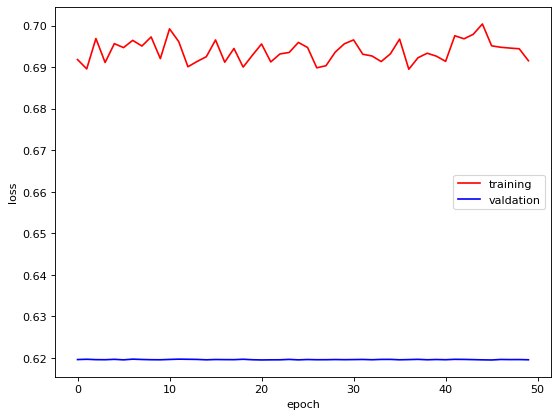

In [36]:
plt.figure(figsize=[8,6], dpi=80)
plt.plot(np.array(train_loss_arr), 'red', label = 'training')
plt.plot(np.array(val_loss_arr), 'blue', label = 'valdation')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt

In [37]:
unique, counts = torch.unique(cnn_train_label, return_counts=True)
print(f"训练集标签分布：{dict(zip(unique.tolist(), counts.tolist()))}")


训练集标签分布：{0: 11845, 1: 377}


In [38]:
# 🟢 1. 评估模式
cnn_model.eval()

# 🟡 2. 训练集预测
with torch.no_grad():
    output = cnn_model(cnn_train_input)
    _, prediction = torch.max(output, axis=1)

# 🟣 3. 计算准确率
correct_num = (prediction == cnn_train_label).sum().item()  # 直接统计正确数
train_accuracy = correct_num / cnn_train_label.size(0)

# ✅ 4. 输出结果
print(f"✅ 训练集准确率：{train_accuracy:.4f}")

✅ 训练集准确率：0.8012


In [39]:
# 🟢 1. 切换为评估模式
cnn_model.eval()

# 🟡 2. 预测验证集
with torch.no_grad():
    output = cnn_model(cnn_val_input)
    _, prediction = torch.max(output, axis=1)

# 🟣 3. 计算准确率
correct_num = (prediction == cnn_val_label).sum().item()
val_accuracy = correct_num / cnn_val_label.size(0)

# ✅ 4. 输出结果
print(f"✅ 验证集准确率：{val_accuracy:.4f}")


✅ 验证集准确率：0.8092


In [56]:
# 生成 RNN 输入 (28 天窗口)
seq_len = 28
X, y = [], []

for i in range(len(data) - seq_len):
    # 直接使用 label 列
    X.append(data[['Close', 'label']].iloc[i:i + seq_len].values)
    y.append(data['Close'].iloc[i + seq_len])  # 预测下一天的 Close

X = np.array(X)  # (样本数, 28, 2)
y = np.array(y)  # (样本数,)

print(f"输入形状：{X.shape}, 目标形状：{y.shape}")





输入形状：(15276, 28, 3), 目标形状：(15276,)


In [59]:
date = data[['Date']].values
date.shape

(15304, 1)

In [60]:
test_date = test_data[['Date']].values
test_date.shape

(253, 1)

In [64]:
rnn_hidden_size = 50
rnn_num_layers = 1
rnn_training_epochs = 200
rnn_learning_rate = 0.001
rnn_output_size = 1

In [65]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers        
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
#         print(x.shape)
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        res, hidden = self.rnn(x, hidden)
        res = self.linear(res)
        return res[:, -1, :], hidden
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden

In [79]:
# # 删除多余的 'label' 列
# data = data.iloc[:,:-1]

# # 检查列名
# print(data.columns)


Index(['Date', 'Close', 'Open', 'High', 'Low', 'PE', 'MA20', 'EMA10', 'RSI',
       'MACD', 'Bollinger_High', 'Bollinger_Low', 'Close_Mean_10',
       'Close_Std_10', 'Daily_Return', 'day_of_week', 'month', 'quarter',
       'is_month_end', 'PE_Close_Corr', 'label'],
      dtype='object')


In [80]:
import numpy as np

# 1. 转换为 NumPy 数组
features = data[['Close', 'label']].values
targets = data['Close'].values

# 2. 生成滑动窗口输入
seq_len = 28
X, y = [], []

for i in range(len(features) - seq_len):
    X.append(features[i:i + seq_len])  # 前28天特征
    y.append(targets[i + seq_len])     # 第29天Close

X = np.array(X)  # (样本数, 28, 2)
y = np.array(y)  # (样本数,)

print(f"输入 X 形状：{X.shape}, 目标 y 形状：{y.shape}")


输入 X 形状：(15276, 28, 2), 目标 y 形状：(15276,)


In [102]:
from sklearn.preprocessing import MinMaxScaler

## 1. 初始化归一化器
#scaler = MinMaxScaler(feature_range=(0, 1))
#
## 2. 仅归一化 Close 列
#data['Close'] = scaler.fit_transform(data[['Close']])

data["Close_transformed"] = data["Close"].pct_change()


# 3. 生成训练数据
X, y = [], []
for i in range(1, len(data) - seq_len):
    X.append(data[['Close_transformed', 'label']].iloc[i:i + seq_len].values)  # Close (已归一化) + label (0/1)
    y.append(data['Close_transformed'].iloc[i + seq_len])                      # 预测下一天 Close

X = torch.tensor(np.array(X), dtype=torch.float32)
y = torch.tensor(np.array(y), dtype=torch.float32).view(-1, 1)

print(f"输入 X 形状：{X.shape}, 目标 y 形状：{y.shape}")



输入 X 形状：torch.Size([15275, 28, 2]), 目标 y 形状：torch.Size([15275, 1])


In [104]:
import torch.nn as nn
import torch.optim as optim

# 损失函数
criterion = nn.MSELoss()

# 优化器
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [105]:
from sklearn.model_selection import train_test_split

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 转换为 PyTorch 张量
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

print(f"训练集输入形状：{X_train.shape}, 训练集目标形状：{y_train.shape}")
print(f"测试集输入形状：{X_test.shape}, 测试集目标形状：{y_test.shape}")


训练集输入形状：torch.Size([12220, 28, 2]), 训练集目标形状：torch.Size([12220, 1])
测试集输入形状：torch.Size([3055, 28, 2]), 测试集目标形状：torch.Size([3055, 1])


C:\Users\yehang\AppData\Local\Temp\ipykernel_33984\3206820862.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
C:\Users\yehang\AppData\Local\Temp\ipykernel_33984\3206820862.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
C:\Users\yehang\AppData\Local\Temp\ipykernel_33984\3206820862.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
C:\Users\yehang\AppData\Local\Tem

In [95]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [107]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

# 初始化模型、损失函数和优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNN(input_size=2, hidden_size=64, output_size=1, num_layers=2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 训练参数
rnn_training_epochs = 100
batch_size = 64

# 记录训练和验证损失
rnn_train_loss_arr = []
rnn_val_loss_arr = []

# 训练模型
for epoch in range(rnn_training_epochs):
    model.train()
    total_train_loss = 0.0

    # 将输入和标签转换为 Variable
    rnn_train_inputv = Variable(X_train).to(device)
    rnn_train_labelv = Variable(y_train).to(device)

    # 1. 前向传播
    output_train, _ = model(rnn_train_inputv)

    # 2. 计算训练损失
    loss = criterion(output_train.reshape(-1), rnn_train_labelv.view(-1))
    rnn_train_loss_arr.append(loss.item())
    total_train_loss += loss.item()

    # 3. 反向传播
    optimizer.zero_grad()
    loss.backward()

    # 4. 更新权重
    optimizer.step()

    # 验证过程
    model.eval()
    with torch.no_grad():
        rnn_val_inputv = Variable(X_test).to(device)
        rnn_val_labelv = Variable(y_test).to(device)

        # 前向传播
        output_val ,_= model(rnn_val_inputv)

        # 计算验证损失
        loss_val = criterion(output_val.reshape(-1), rnn_val_labelv.view(-1))
        rnn_val_loss_arr.append(loss_val.item())

    # 每10个epoch打印一次损失
    if (epoch % 10 == 0 or epoch == rnn_training_epochs - 1):
        print(f"[{epoch}/{rnn_training_epochs}] 训练损失: {loss.item():.7f}, 验证损失: {loss_val.item():.7f}")

print("🎉 训练完成！")


[0/100] 训练损失: 0.0012046, 验证损失: 0.0006281
[10/100] 训练损失: 0.0001573, 验证损失: 0.0001706
[20/100] 训练损失: 0.0001176, 验证损失: 0.0001627
[30/100] 训练损失: 0.0001049, 验证损失: 0.0001593
[40/100] 训练损失: 0.0001007, 验证损失: 0.0001575
[50/100] 训练损失: 0.0000996, 验证损失: 0.0001575
[60/100] 训练损失: 0.0000983, 验证损失: 0.0001546
[70/100] 训练损失: 0.0000967, 验证损失: 0.0001537
[80/100] 训练损失: 0.0000958, 验证损失: 0.0001533
[90/100] 训练损失: 0.0000955, 验证损失: 0.0001531
[99/100] 训练损失: 0.0000952, 验证损失: 0.0001532
🎉 训练完成！


In [ ]:
# Begin test for CNN + RNN using test_data

In [109]:
##Converting the test dataset into imgae

# 创建保存测试图片的文件夹
test_image_dir = './test_images/'
os.makedirs(test_image_dir, exist_ok=True)

# 生成测试集图片
window_size = 28
for i in range(window_size, len(test_data)):
    data_window = test_data['Close'].iloc[i - window_size:i]

    plt.figure(figsize=(8, 8))
    plt.plot(data_window, color='black')
    plt.axis('off')  # 不显示坐标轴
    plt.savefig(f"{test_image_dir}day{i}.png", bbox_inches='tight', pad_inches=0)
    plt.close()

print(f"✅ 测试集图片生成完成，保存于：{test_image_dir}")


✅ 测试集图片生成完成，保存于：./test_images/


In [110]:

# 读取测试集图片并转换为 CNN 输入
cnn_test_input = []

for i in range(window_size, len(test_data)):
    image_path = f"{test_image_dir}day{i}.png"
    img = Image.open(image_path)
    img = img.convert("L")  # 转为灰度图
    img_resize = img.resize((180, 180))  # 调整为CNN期望的尺寸
    cnn_test_input.append(np.asarray(img_resize) / 255.0)

# 转换为 PyTorch 张量
cnn_test_input = torch.tensor(np.array(cnn_test_input), dtype=torch.float32).view(-1, 1, 180, 180).to(device)

print(f"测试输入形状：{cnn_test_input.shape}")


测试输入形状：torch.Size([225, 1, 180, 180])


In [119]:
test_data

,Date,Close,Open,High,Low,PE,MA20,EMA10,RSI,MACD,...,Close_Mean_10,Close_Std_10,Daily_Return,day_of_week,month,quarter,is_month_end,PE_Close_Corr,Sell_Label,label
15051,2020-01-02,3257.85,3244.67,3258.14,3235.53,30.99,3188.1260,3223.101422,75.483057,36.192742,...,3225.497,18.623351,0.008379,3,1,1,0,0.523066,0,0
15052,2020-01-03,3234.85,3226.36,3246.15,3222.34,30.99,3194.2305,3225.237527,65.738926,34.913483,...,3229.868,14.288618,-0.007060,4,1,1,0,0.524455,0,0
15053,2020-01-06,3246.28,3217.55,3246.84,3214.64,30.99,3200.6730,3229.063431,67.952962,34.425134,...,3233.959,12.198909,0.003533,0,1,1,0,0.535793,0,0
15054,2020-01-07,3237.18,3241.86,3244.91,3232.43,30.99,3205.2365,3230.539171,64.385561,32.924290,...,3235.555,11.362419,-0.002803,1,1,1,0,0.544707,0,0
15055,2020-01-08,3253.05,3238.59,3267.07,3236.67,30.99,3211.0910,3234.632049,67.581890,32.639192,...,3238.459,11.786984,0.004902,2,1,1,0,0.567625,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15299,2020-12-24,3703.06,3694.03,3703.82,3689.32,33.77,3680.3145,3691.201113,61.278722,36.431219,...,3691.388,21.787600,0.003537,3,12,4,0,0.858996,0,0
15300,2020-12-28,3735.36,3723.03,3740.51,3723.03,33.77,3685.1650,3699.230001,65.834249,37.531539,...,3698.578,23.354510,0.008723,0,12,4,0,0.854354,0,0
15301,2020-12-29,3727.04,3750.01,3756.12,3723.31,33.77,3690.4355,3704.286365,63.753598,37.302198,...,3706.533,16.587076,-0.002227,1,12,4,0,0.845075,0,0
15302,2020-12-30,3732.04,3736.19,3744.63,3730.21,33.77,3693.9150,3709.332480,64.480123,37.096280,...,3710.275,17.779019,0.001342,2,12,4,0,0.823732,0,0


In [120]:
cnn_model.eval()
with torch.no_grad():
    cnn_output = cnn_model(cnn_test_input)
    _, sell_label = torch.max(cnn_output, axis=1)

# 5️⃣ 补 0 处理前28天的空缺
sell_label_full = np.zeros(len(test_data))
sell_label_full[window_size:window_size + len(sell_label)] = sell_label.cpu().numpy()

# 6️⃣ 将 Sell Label 添加到测试数据
test_data['label'] = sell_label_full.astype(int)

In [125]:
count_ones = test_data['label'].sum()
print(f"Count of 1s in test_data label column: {count_ones}")


Count of 1s in test_data label column: 30


In [135]:
test_data["Close_transformed"] = test_data["Close"].pct_change()
test_data

,Date,Close,Open,High,Low,PE,MA20,EMA10,RSI,MACD,...,Close_Std_10,Daily_Return,day_of_week,month,quarter,is_month_end,PE_Close_Corr,Sell_Label,label,Close_transformed
15051,2020-01-02,3257.85,3244.67,3258.14,3235.53,30.99,3188.1260,3223.101422,75.483057,36.192742,...,18.623351,0.008379,3,1,1,0,0.523066,0,0,NaN
15052,2020-01-03,3234.85,3226.36,3246.15,3222.34,30.99,3194.2305,3225.237527,65.738926,34.913483,...,14.288618,-0.007060,4,1,1,0,0.524455,0,0,-0.007060
15053,2020-01-06,3246.28,3217.55,3246.84,3214.64,30.99,3200.6730,3229.063431,67.952962,34.425134,...,12.198909,0.003533,0,1,1,0,0.535793,0,0,0.003533
15054,2020-01-07,3237.18,3241.86,3244.91,3232.43,30.99,3205.2365,3230.539171,64.385561,32.924290,...,11.362419,-0.002803,1,1,1,0,0.544707,0,0,-0.002803
15055,2020-01-08,3253.05,3238.59,3267.07,3236.67,30.99,3211.0910,3234.632049,67.581890,32.639192,...,11.786984,0.004902,2,1,1,0,0.567625,0,0,0.004902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15299,2020-12-24,3703.06,3694.03,3703.82,3689.32,33.77,3680.3145,3691.201113,61.278722,36.431219,...,21.787600,0.003537,3,12,4,0,0.858996,0,0,0.003537
15300,2020-12-28,3735.36,3723.03,3740.51,3723.03,33.77,3685.1650,3699.230001,65.834249,37.531539,...,23.354510,0.008723,0,12,4,0,0.854354,0,0,0.008723
15301,2020-12-29,3727.04,3750.01,3756.12,3723.31,33.77,3690.4355,3704.286365,63.753598,37.302198,...,16.587076,-0.002227,1,12,4,0,0.845075,0,0,-0.002227
15302,2020-12-30,3732.04,3736.19,3744.63,3730.21,33.77,3693.9150,3709.332480,64.480123,37.096280,...,17.779019,0.001342,2,12,4,0,0.823732,0,0,0.001342


In [136]:
X_test, y_test = [], []

for i in range(len(test_data) - window_size):
    X_test.append(test_data[['Close_transformed', 'label']].iloc[i:i + window_size].values)
    y_test.append(test_data['Close_transformed'].iloc[i + window_size])

X_test = torch.tensor(np.array(X_test), dtype=torch.float32).to(device)
y_test = torch.tensor(np.array(y_test), dtype=torch.float32).view(-1, 1).to(device)

In [163]:
model.eval()
with torch.no_grad():
    predicted_return, _ = model(X_test)
predicted_return

tensor([[        nan],
        [ 6.5699e-04],
        [ 6.0145e-04],
        [ 6.1767e-04],
        [ 6.7081e-04],
        [ 6.6521e-04],
        [ 6.7797e-04],
        [ 7.2606e-04],
        [ 9.2284e-04],
        [ 1.1514e-03],
        [ 1.2282e-03],
        [ 1.2204e-03],
        [ 3.0115e-04],
        [-1.1762e-03],
        [-3.1805e-03],
        [-4.2333e-03],
        [-3.4069e-03],
        [-5.8344e-03],
        [-1.6833e-03],
        [-1.7285e-04],
        [-2.4720e-03],
        [ 2.0369e-03],
        [ 1.6532e-03],
        [-2.9315e-04],
        [ 1.3797e-03],
        [ 4.9384e-04],
        [ 8.3956e-04],
        [ 1.2497e-03],
        [ 7.9478e-04],
        [ 1.2192e-03],
        [-3.4042e-04],
        [ 4.0662e-04],
        [-5.3434e-04],
        [ 8.0828e-05],
        [-8.0690e-04],
        [-1.3457e-03],
        [-2.4210e-03],
        [-3.3189e-03],
        [-4.4611e-04],
        [-2.8208e-03],
        [ 1.2118e-03],
        [-5.7742e-06],
        [-5.7967e-04],
        [ 3

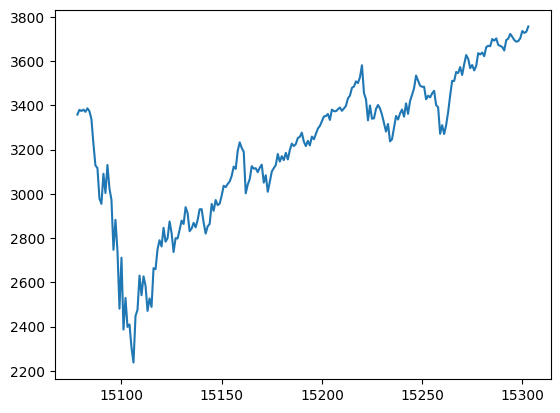

In [162]:
plt.plot(test_data['Close'].iloc[window_size - 1:])

In [166]:
initial_price = test_data['Close'].iloc[window_size - 1]  # 第28天的价格

# 通过累积收益率恢复价格
predicted_price = initial_price * (1 + pd.Series(predicted_return.numpy().flatten())).cumprod()

predicted_price = predicted_price.dropna()

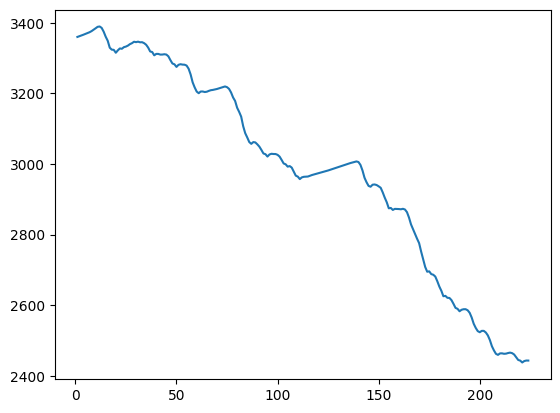

In [167]:
plt.plot(predicted_price)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
true_prices = test_data['Close'].iloc[window_size+1:].values

mae = mean_absolute_error(true_prices, predicted_price)
rmse = np.sqrt(mean_squared_error(true_prices, predicted_price))

print(f"✅ 测试集 MAE: {mae:.2f}, RMSE: {rmse:.2f}")

✅ 测试集 MAE: 532.12, RMSE: 641.45


In [236]:
test_data[28:]

,Date,Close,Open,High,Low,PE,MA20,EMA10,RSI,MACD,...,Close_Std_10,Daily_Return,day_of_week,month,quarter,is_month_end,PE_Close_Corr,Sell_Label,label,Close_transformed
15079,2020-02-12,3379.45,3370.50,3381.47,3369.72,30.73,3307.2850,3330.557563,66.372258,30.202750,...,50.012469,0.006463,2,2,1,0,-0.567490,0,0,0.006463
15080,2020-02-13,3373.94,3365.90,3385.09,3360.52,30.73,3311.5175,3338.445279,65.021817,31.884953,...,51.780355,-0.001630,3,2,1,0,-0.600945,0,0,-0.001630
15081,2020-02-14,3380.16,3378.08,3380.69,3366.15,30.73,3314.6850,3346.029773,65.866120,33.335740,...,40.945406,0.001844,4,2,1,0,-0.625291,0,0,0.001844
15082,2020-02-18,3370.29,3369.04,3375.01,3355.61,30.73,3316.7185,3350.440724,63.256845,33.305151,...,26.424300,-0.002920,1,2,1,0,-0.641567,0,0,-0.002920
15083,2020-02-19,3386.15,3380.39,3393.52,3378.83,30.73,3319.9865,3356.933319,65.614112,34.166825,...,20.318086,0.004706,2,2,1,0,-0.653274,0,0,0.004706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15299,2020-12-24,3703.06,3694.03,3703.82,3689.32,33.77,3680.3145,3691.201113,61.278722,36.431219,...,21.787600,0.003537,3,12,4,0,0.858996,0,0,0.003537
15300,2020-12-28,3735.36,3723.03,3740.51,3723.03,33.77,3685.1650,3699.230001,65.834249,37.531539,...,23.354510,0.008723,0,12,4,0,0.854354,0,0,0.008723
15301,2020-12-29,3727.04,3750.01,3756.12,3723.31,33.77,3690.4355,3704.286365,63.753598,37.302198,...,16.587076,-0.002227,1,12,4,0,0.845075,0,0,-0.002227
15302,2020-12-30,3732.04,3736.19,3744.63,3730.21,33.77,3693.9150,3709.332480,64.480123,37.096280,...,17.779019,0.001342,2,12,4,0,0.823732,0,0,0.001342


In [251]:
np.mean((predicted_return.squeeze(-1).numpy() - test_data[28:]["Close_transformed"])**2)

np.float64(0.0005247503582863651)

In [252]:
np.mean((predicted_return_base.squeeze(-1).numpy() - test_data[28:]["Close_transformed"])**2)

np.float64(0.0005308950696986374)

In [245]:
0.0005247503582863651 / 0.0005308950696986374

0.9884257515976551

In [ ]:
# Evaluate the RNN model

In [173]:

# 2️⃣ 生成 RNN 输入（仅使用 Close_transformed）
X_test_baseline =[]
for i in range(len(test_data) - window_size):
    # 仅使用 Close_transformed 作为输入
    X_test_baseline.append(test_data[['Close_transformed']].iloc[i:i + window_size].values)

X_test_baseline = torch.tensor(np.array(X_test_baseline), dtype=torch.float32).to(device)

In [175]:
# 3️⃣ 使用 RNN 预测每日 Return
model.eval()
with torch.no_grad():
    predicted_return_baseline,_ = model(X_test_baseline)


RuntimeError: input.size(-1) must be equal to input_size. Expected 2, got 1

In [ ]:

# 4️⃣ 将 Return 转换回 Close Price
initial_price = test_data['Close'].iloc[window_size - 1]  # 以第28天的 Close 作为基准
predicted_price_baseline = initial_price * (1 + pd.Series(predicted_return_baseline)).cumprod()

# 5️⃣ 评估模型表现
true_prices = test_data['Close'].iloc[window_size:].values

mae_baseline = mean_absolute_error(true_prices, predicted_price_baseline)
rmse_baseline = np.sqrt(mean_squared_error(true_prices, predicted_price_baseline))

print(f"📊 **基准模型 (不含 Label)**：MAE = {mae_baseline:.2f}, RMSE = {rmse_baseline:.2f}")

# 6️⃣ 可视化真实值 vs 预测值
plt.figure(figsize=(14, 8))
plt.plot(true_prices, label='真实价格', color='blue')
plt.plot(predicted_price_baseline, label='RNN 预测价格 (无 Label)', color='orange')
plt.legend()
plt.xlabel('时间')
plt.ylabel('Close Price')
plt.title('RNN 预测效果：不含 Sell Label')
plt.grid(True)
plt.show()

In [223]:
base_rnn_model = RNN(input_size=1, output_size=1, hidden_size=64, num_layers=2).to(device)

# 初始化模型、损失函数和优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()
optimizer = optim.Adam(base_rnn_model.parameters(), lr=1e-4)

# 训练参数
rnn_training_epochs = 100
batch_size = 64

# 记录训练和验证损失
rnn_train_loss_arr = []
rnn_val_loss_arr = []

# 训练模型
for epoch in range(rnn_training_epochs):
    base_rnn_model.train()
    total_train_loss = 0.0

    # 将输入和标签转换为 Variable
    rnn_train_inputv = Variable(X_train[:,:,0].unsqueeze(-1)).to(device)
    rnn_train_labelv = Variable(y_train).to(device)

    # 1. 前向传播
    output_train, _ = base_rnn_model(rnn_train_inputv)

    # 2. 计算训练损失
    loss = criterion(output_train.reshape(-1)[:-1], rnn_train_labelv.view(-1)[1:])
    rnn_train_loss_arr.append(loss.item())
    total_train_loss += loss.item()

    # 3. 反向传播
    optimizer.zero_grad()
    loss.backward()

    # 4. 更新权重
    optimizer.step()

    # 验证过程
    base_rnn_model.eval()
    with torch.no_grad():
        rnn_val_inputv = Variable(X_test[:,:,0].unsqueeze(-1)).to(device)
        rnn_val_labelv = Variable(y_test).to(device)

        # 前向传播
        output_val ,_= base_rnn_model(rnn_val_inputv)

        # 计算验证损失
        loss_val = criterion(output_val.reshape(-1)[1:-1], rnn_val_labelv.view(-1)[2:])
        rnn_val_loss_arr.append(loss_val.item())

    # 每10个epoch打印一次损失
    if (epoch % 10 == 0 or epoch == rnn_training_epochs - 1):
        print(f"[{epoch}/{rnn_training_epochs}] 训练损失: {loss.item():.7f}, 验证损失: {loss_val.item():.7f}")

[0/100] 训练损失: 0.0001854, 验证损失: 0.0005372
[10/100] 训练损失: 0.0001114, 验证损失: 0.0005360
[20/100] 训练损失: 0.0000998, 验证损失: 0.0005217
[30/100] 训练损失: 0.0000964, 验证损失: 0.0005167
[40/100] 训练损失: 0.0000953, 验证损失: 0.0005147
[50/100] 训练损失: 0.0000945, 验证损失: 0.0005139
[60/100] 训练损失: 0.0000942, 验证损失: 0.0005140
[70/100] 训练损失: 0.0000942, 验证损失: 0.0005146
[80/100] 训练损失: 0.0000941, 验证损失: 0.0005153
[90/100] 训练损失: 0.0000941, 验证损失: 0.0005157
[99/100] 训练损失: 0.0000941, 验证损失: 0.0005161


In [226]:
base_rnn_model.eval()
with torch.no_grad():
    predicted_return_base, _ = base_rnn_model(X_test[:,:,0].unsqueeze(-1))
predicted_return_base

tensor([[        nan],
        [ 4.2756e-04],
        [ 3.8885e-04],
        [ 3.7611e-04],
        [ 3.8786e-04],
        [ 4.3328e-04],
        [ 3.0859e-04],
        [ 2.1420e-05],
        [-3.8154e-04],
        [-4.1928e-04],
        [ 2.0590e-04],
        [-9.8989e-04],
        [-6.4577e-04],
        [ 1.1862e-03],
        [-9.1117e-04],
        [ 3.4300e-04],
        [ 1.7414e-04],
        [-6.7175e-04],
        [-7.2323e-04],
        [ 1.0250e-03],
        [-4.2996e-04],
        [-3.4312e-03],
        [ 2.4145e-03],
        [-2.0922e-03],
        [-8.7342e-04],
        [ 5.2622e-04],
        [-1.5895e-03],
        [-1.3711e-04],
        [-1.2296e-03],
        [ 2.3095e-03],
        [ 3.2679e-04],
        [ 3.5375e-04],
        [ 4.7329e-04],
        [ 1.0663e-03],
        [ 1.4259e-03],
        [-8.1268e-04],
        [ 1.3152e-03],
        [ 3.7822e-04],
        [ 1.1472e-03],
        [ 6.0958e-04],
        [ 3.7644e-04],
        [ 1.5857e-03],
        [ 2.9806e-04],
        [ 1

In [228]:
initial_price = test_data['Close'].iloc[window_size - 1]  # 第28天的价格

# 通过累积收益率恢复价格
predicted_price_base = initial_price * (1 + pd.Series(predicted_return_base.numpy().flatten())).cumprod()

predicted_price_base = predicted_price_base.dropna()

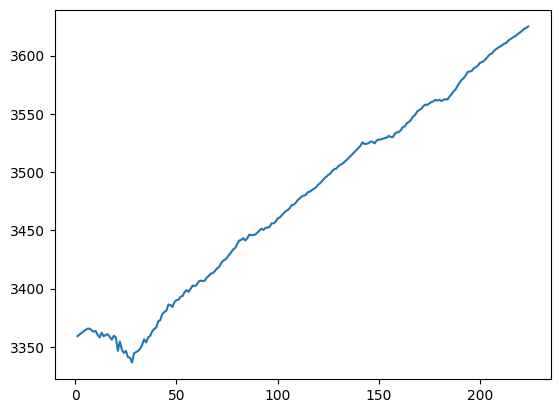

In [229]:
plt.plot(predicted_price_base)

In [231]:
true_prices = test_data['Close'].iloc[window_size+1:].values

mae = mean_absolute_error(true_prices, predicted_price_base)
rmse = np.sqrt(mean_squared_error(true_prices, predicted_price_base))

print(f"✅ 测试集 MAE: {mae:.2f}, RMSE: {rmse:.2f}")

✅ 测试集 MAE: 288.28, RMSE: 376.26
